In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input #Visual Geometry Group 16-layer network ✅
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#pip install tensorflow tensorflow-datasets


In [3]:
tf.config.optimizer.set_jit(False) #telling TensorFlow not to use XLA JIT compilation XLA (Accelerated Linear Algebra)
#When JIT is enabled, TensorFlow tries to speed up model execution.sometimes JIT can cause instability,

In [4]:
# Step 1: Load Dataset
# -----------------------------------------------------
train_ds, test_ds = tfds.load(
    "tf_flowers",               #built-in dataset
    split=["train[:70%]", "train[:30%]"],      #manually divide it
    as_supervised=True   # returns (image, label) in tuple format , else as a dictionary
)

In [5]:
# Step 2: Preprocessing Function
# -----------------------------------------------------
NUM_CLASSES = 5                                     #Daisy, Dandelion, Roses, Sunflowers, Tulips
IMG_SIZE = (150, 150)                               # define target size 

In [6]:
def preprocess(image, label):
    # Resize
    image = tf.image.resize(image, IMG_SIZE)
    # Preprocess for VGG16
    image = preprocess_input(image)                     # Prepares your image data so it matches what the VGG16 model expects
    # One-hot encode labels
    label = tf.one_hot(label, NUM_CLASSES)             # Converts an integer label into a one-hot encoded vector
    return image, label

In [7]:
# Apply preprocessing + batching
train_ds = (train_ds
            .map(preprocess,                                   #custom function made by us 
                 num_parallel_calls=tf.data.AUTOTUNE)          # TensorFlow will automatically decide the optimal number of parallel threads to speed up the mapping process
            .shuffle(1000)                                     # shuffles the dataset with a buffer size of 1000 elements, helps generalize better
            .batch(32)                                         # Groups samples into mini-batches of 32 images before feeding them to the model
            .prefetch(tf.data.AUTOTUNE))                       # asynchronous data loading: while the model is training on one batch, TensorFlow is already preparing the next one in the background.

In [8]:
test_ds = (test_ds
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(32)
           .prefetch(tf.data.AUTOTUNE))

In [9]:
# Step 3: Load Pre-trained Model (VGG16)
# -----------------------------------------------------
base_model = VGG16(weights="imagenet",             #VGG16 ( 13 CNN and 3 dense ) total 16 layers , load pretrained weights learned from ImageNet Dataset
                   include_top=False,              # removes those final layers and keeps only the convolutional base
                   input_shape=(150, 150, 3))      # Specifies the size and format of the images you’ll feed into the network , 150 x 150 and 3 (RGB) channels

In [10]:
base_model.trainable = False  # freeze convolutional base

#TensorFlow not to update the weights of the pre-trained VGG16 convolutional layers during training

In [11]:
    # Custom classifier
    model = models.Sequential([
        base_model,                  # frozen VGG16 convolutional base It extracts useful features from the images like edges, shapes, colors, textures, etc.
        layers.Flatten(),            # flatten 3D feature maps into 1D vector
        layers.Dense(50, activation='relu'),  # first fully-connected hidden layer, 50 neurons
        layers.Dense(20, activation='relu'),  # second hidden layer, 20 neurons 
        layers.Dense(NUM_CLASSES, activation='softmax')  # output layer, 5 classes , probabilities sum
    ])

In [12]:
# Step 4: Compile & Train
# -----------------------------------------------------
model.compile(optimizer='adam',                         #adjusts the learning rate for each parameter automatically.
              loss='categorical_crossentropy',          # Measures how far the predicted probabilities are from the true labels.
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy',              # Checks the validation accuracy after each epoch to decide whether to stop training
                   mode='max',                          # Because we want accuracy to increase, max tells Keras to stop if it stops improving
                   patience=5,                          # If val_accuracy does not improve for 5 consecutive epochs, training will stop early to avoid overfitting.
                   restore_best_weights=True)           # after stopping, it automatically restores the model to the best stateidation accuracy, not the last epoch.

In [ ]:
history = model.fit(
    train_ds,                     # training data (images + labels)
    epochs=5,                     # number of times the model sees all training data
    validation_data=test_ds,      # used to check model performance after each epoch
    callbacks=[es]                # uses EarlyStopping to stop training early if needed
)


Epoch 1/5
58/81 ━━━━━━━━━━━━━━━━━━━━ 2:14 6s/step - accuracy: 0.4735 - loss: 3.8098

In [ ]:
# -----------------------------------------------------
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss, "Accuracy:", accuracy)

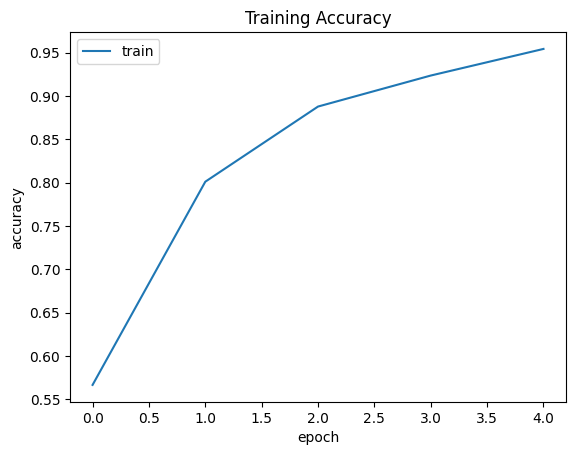

In [17]:
# Step 6: Plot Accuracy
# -----------------------------------------------------
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:

#Optional
# Step 10: Predictions
# --------------------------------------
y_pred = model.predict(test_ds)
y_classes = np.argmax(y_pred, axis=1)

print("Predicted classes (first 10):", y_classes[:10])
print("True labels (first 10):", np.argmax(test_labels[:10], axis=1))

# -----------------------------------------------------
# Step 5: Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss, "Accuracy:", accuracy)


# -----------------------------------------------------
# Step 6: Fine-tune hyperparameters and unfreeze more layers
# -----------------------------------------------------

# 1️ Unfreeze the convolutional base
base_model.trainable = True   # Allow training for some layers

# 2️ Freeze the first few layers of VGG16 (these learn general features)
for layer in base_model.layers[:10]:
    layer.trainable = False

# 3️ Recompile the model with a smaller learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4️Continue training the model (fine-tuning stage)
history_fine = model.fit(
    train_ds,
    epochs=3,                     # fewer epochs for fine-tuning
    validation_data=test_ds,
    callbacks=[es]
)

# 5️ Re-evaluate after fine-tuning
loss_fine, accuracy_fine = model.evaluate(test_ds)
print("Fine-tuned Loss:", loss_fine)
print("Fine-tuned Accuracy:", accuracy_fine)
